# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [10]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [26]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from torch.utils.data.sampler import SubsetRandomSampler

In [27]:
# Check GPU situation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [59]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create training set and define training dataloader
## YOUR CODE HERE ##
training_data = torchvision.datasets.MNIST(root = "data", download = True, train = True, transform = transform)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = torchvision.datasets.MNIST(root = "data", download = True, train = False, transform = transform)

In [60]:
def get_train_val_data_loaders(train_data, batch_size, valid_size, transforms, num_workers):

    # Compute how many items we will reserve for the validation set
    n_tot = len(train_data)
    split = int(np.floor(valid_size * n_tot))

    # compute the indices for the training set and for the validation set
    shuffled_indices = torch.randperm(n_tot)
    train_idx, valid_idx = shuffled_indices[split:], shuffled_indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
    )
    valid_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
    )

    return train_loader, valid_loader

In [61]:
def get_test_data_loader(test_data, batch_size, transforms, num_workers):
    # We use the entire test dataset in the test dataloader
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )

    return test_loader

In [62]:
# number of subprocesses to use for data loading
num_workers = 1
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

train_dl, valid_dl = get_train_val_data_loaders(training_data, batch_size, valid_size, transforms, num_workers)
test_dl = get_test_data_loader(test_data, batch_size, transforms, num_workers)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I normalized it with a mean and standard deviation of 0.5 in the grey scale. Normalizing the images would help the neural network train easier. 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img, sub):
    img = img / 2 + 0.5  # unnormalize
    sub.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    sub.axis("off")

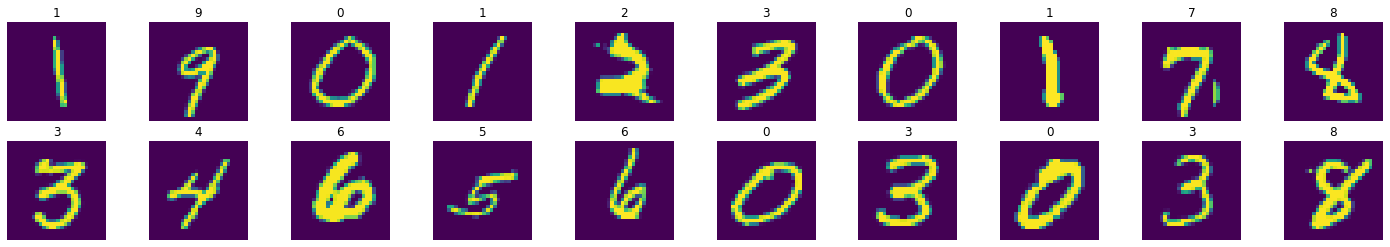

In [64]:
# obtain one batch of training images
dataiter = iter(train_dl)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
# display 20 images
# NOTE: make sure your batch size is at least 20
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for i, sub in enumerate(subs.flatten()):
    imshow(images[i], sub)
    sub.set_title(int(labels[i].detach()))

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [65]:
# Test the size of the image
dataiter = iter(train_dl)
batch = next(dataiter)
images_size = batch[0][0].size()
images_size

torch.Size([1, 28, 28])

In [66]:
## YOUR CODE HERE ##
## Define the neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28 * 1, 120) ## flatten the image
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 32)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [67]:
## YOUR CODE HERE ##
# Choose an optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Choose cross entropy loss as the loss
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [68]:
len(train_dl)

480

In [69]:
numTrainLoader = 0;
for i in enumerate(train_dl):
    numTrainLoader += 1
print(numTrainLoader)

480


In [70]:
num_epochs = 2 ## Define how many epochs

In [71]:
## YOUR CODE HERE ##

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

num_correct_train = 0;
num_correct_test = 0;

for epoch in range(num_epochs):
#     print("Epoch:", epoch)
    ## Tell the network it's in the training mode
    net.train()
    ## Define the training loss and number of correct predictions
    train_num_batch = 0
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_dl):
#         print("    label:", i)
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        # Set the gradients to be zero
        optimizer.zero_grad()
    
        # Calculate the output via the neural network
        outputs = net(inputs)
        # Calculate the loss via the criterion
        loss = criterion(outputs, labels)
        ## The gradients are "stored" by the tensors themselves
        loss.backward()
        ## The optimizer iterates over all parameters (tensors) and update the gradient
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        train_num_batch += 1
    num_correct_train = max(num_correct_train, train_correct)
    print("num of samples:",train_num_batch)
    print("lenth of train loader:",len(train_dl))
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/train_num_batch:.2f}% training loss: {train_loss/train_num_batch:.5f}')
    train_loss_history.append(train_loss/train_num_batch)
    
    val_num_batch = 0
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in valid_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
        val_num_batch += 1
    num_correct_test = max(num_correct_test, val_correct)
    print("num of samples:",val_num_batch)
    print("lenth of validation loader:",len(valid_dl))
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/val_num_batch:.2f}% validation loss: {val_loss/val_num_batch:.5f}')
    val_loss_history.append(val_loss/val_num_batch)
    

num of samples: 480
lenth of train loader: 480
Epoch 1 training accuracy: 84.10% training loss: 0.51929
num of samples: 120
lenth of validation loader: 120
Epoch 1 validation accuracy: 91.40% validation loss: 0.28212
num of samples: 480
lenth of train loader: 480
Epoch 2 training accuracy: 92.65% training loss: 0.24047
num of samples: 120
lenth of validation loader: 120
Epoch 2 validation accuracy: 93.10% validation loss: 0.21830


Plot the training loss (and validation loss/accuracy, if recorded).

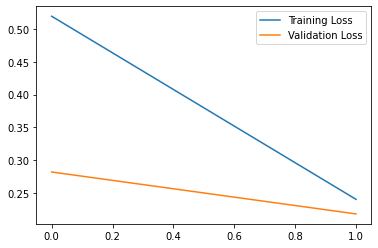

In [72]:
## YOUR CODE HERE ##
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [75]:
from tqdm import tqdm

In [76]:
def one_epoch_test(test_dataloader, model, loss):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # we do not need the gradients
    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()  # -

        # if the GPU is available, move the model to the GPU
        if torch.cuda.is_available():
            model = model.cuda()

        # Loop over test dataset
        # We also accumulate predictions and targets so we can return them
        preds = []
        actuals = []
        
        for batch_idx, (data, target) in tqdm(
                enumerate(test_dataloader),
                desc='Testing',
                total=len(test_dataloader),
                leave=True,
                ncols=80
        ):
            # move data to GPU if available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)  # =
            # 2. calculate the loss
            loss_value = loss(logits, target).detach()  # =

            # update average test loss
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss_value.data.item() - test_loss))

            # convert logits to predicted class
            # NOTE: the predicted class is the index of the max of the logits
            pred = logits.data.max(1, keepdim=True)[1]  # =

            # compare predictions to true label
            correct += torch.sum(torch.squeeze(pred.eq(target.data.view_as(pred))).cpu())
            total += data.size(0)
            
            preds.extend(pred.data.cpu().numpy().squeeze())
            actuals.extend(target.data.view_as(pred).cpu().numpy().squeeze())

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    return test_loss, preds, actuals, correct, total

In [77]:
test_loss, preds, actuals, correct, total = one_epoch_test(test_dl, net, criterion)

Testing: 100%|████████████████████████████████| 100/100 [00:02<00:00, 41.10it/s]

Test Loss: 0.205538


Test Accuracy: 93% (9369/10000)


In [86]:
## YOUR CODE HERE ##
## As calculated in the previous code block, the training accuracy is, and the testing accuracy is
accuracy_train = num_correct_train/len(train_dl)
accuracy_test = correct/total

In [87]:
print(accuracy_train)

92.64791666666666


In [88]:
print(accuracy_test)

tensor(0.9369)


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [89]:
## YOUR CODE HERE ##
## The changes I made: 
## I increased the number of epochs used
num_epochs = 10 ## Define how many epochs
## YOUR CODE HERE ##

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

num_correct_train = 0;
num_correct_test = 0;

for epoch in range(num_epochs):
#     print("Epoch:", epoch)
    ## Tell the network it's in the training mode
    net.train()
    ## Define the training loss and number of correct predictions
    train_num_batch = 0
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_dl):
#         print("    label:", i)
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        # Set the gradients to be zero
        optimizer.zero_grad()
    
        # Calculate the output via the neural network
        outputs = net(inputs)
        # Calculate the loss via the criterion
        loss = criterion(outputs, labels)
        ## The gradients are "stored" by the tensors themselves
        loss.backward()
        ## The optimizer iterates over all parameters (tensors) and update the gradient
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        train_num_batch += 1
    num_correct_train = max(num_correct_train, train_correct)
    print("num of samples:",train_num_batch)
    print("lenth of train loader:",len(train_dl))
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/train_num_batch:.2f}% training loss: {train_loss/train_num_batch:.5f}')
    train_loss_history.append(train_loss/train_num_batch)
    
    val_num_batch = 0
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in valid_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
        val_num_batch += 1
    num_correct_test = max(num_correct_test, val_correct)
    print("num of samples:",val_num_batch)
    print("lenth of train loader:",len(valid_dl))
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/val_num_batch:.2f}% validation loss: {val_loss/val_num_batch:.5f}')
    val_loss_history.append(val_loss/val_num_batch)

num of samples: 480
lenth of train loader: 480
Epoch 1 training accuracy: 94.82% training loss: 0.17023
num of samples: 120
lenth of train loader: 120
Epoch 1 validation accuracy: 94.88% validation loss: 0.17071
num of samples: 480
lenth of train loader: 480
Epoch 2 training accuracy: 95.90% training loss: 0.13489
num of samples: 120
lenth of train loader: 120
Epoch 2 validation accuracy: 95.59% validation loss: 0.14699
num of samples: 480
lenth of train loader: 480
Epoch 3 training accuracy: 96.50% training loss: 0.11352
num of samples: 120
lenth of train loader: 120
Epoch 3 validation accuracy: 95.90% validation loss: 0.13249
num of samples: 480
lenth of train loader: 480
Epoch 4 training accuracy: 97.03% training loss: 0.09515
num of samples: 120
lenth of train loader: 120
Epoch 4 validation accuracy: 95.63% validation loss: 0.14343
num of samples: 480
lenth of train loader: 480
Epoch 5 training accuracy: 97.35% training loss: 0.08478
num of samples: 120
lenth of train loader: 120
E

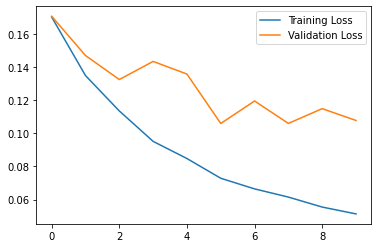

In [92]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
## Test the model again
test_loss, preds, actuals, correct, total = one_epoch_test(test_dl, net, criterion)

## Saving your model
Using `torch.save`, save your model for future loading.

In [91]:
## YOUR CODE HERE ##
torch.save(net, "./model")